# PREPARATIONS

In [1]:
##### LIBRARIES

import numpy as np
import pandas as pd

import torch
import torchvision

from torchvision import transforms, datasets
from torch.utils.data import Dataset

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm

import random
import time
import sys
import os
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
##### CUSTOM MODULES

sys.path.append('../codes')
from preprocessing import *
from data import EyeData

In [2]:
##### SETTINGS

pd.set_option('display.max_columns', None)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# DATA IMPORT

In [3]:
##### CHECK DIMENSIONS

# import data
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test  = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train['diagnosis'].value_counts(normalize = True))

(3662, 2) (1928, 2)
---------------
0    0.492900
2    0.272802
1    0.101038
4    0.080557
3    0.052703
Name: diagnosis, dtype: float64


# DATA EXPLORATION

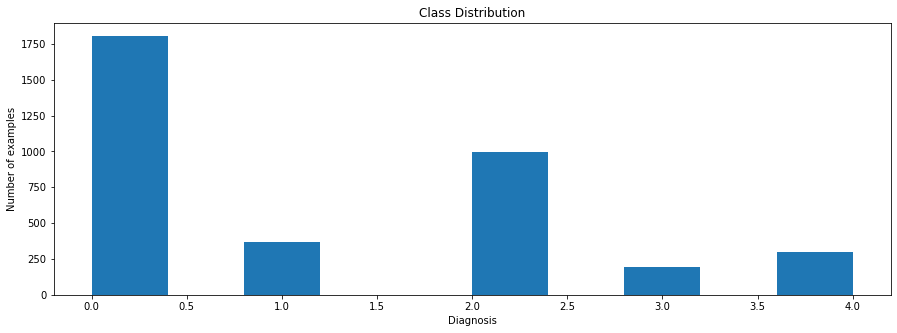

In [4]:
##### CLASS DISTRIBUTION

# plot
fig = plt.figure(figsize = (15, 5))
plt.hist(train['diagnosis'])
plt.title('Class Distribution')
plt.ylabel('Number of examples')
plt.xlabel('Diagnosis')

# export
plt.savefig('../figures/fig_class_distribution.pdf')

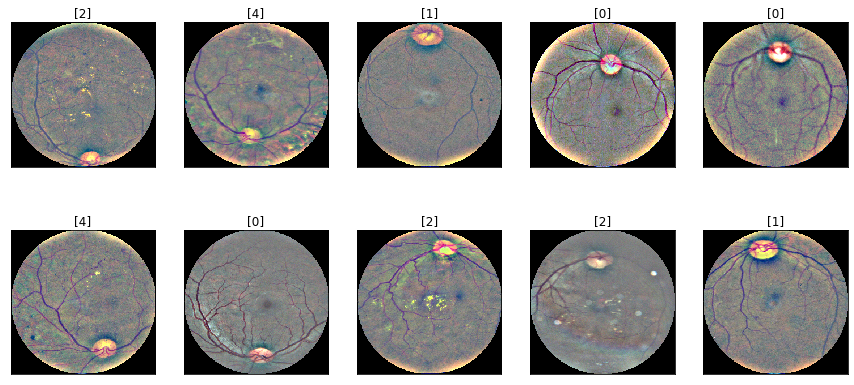

In [7]:
##### EXAMINE SAMPLE BATCH

image_size = 256


# transformations
sample_trans = transforms.Compose([transforms.ToPILImage(),
                                   transforms.ToTensor(),
                                  ])

# dataset
sample = EyeData(data       = train, 
                 directory  = '../input/aptos2019-blindness-detection/train_images',
                 transform  = sample_trans)

# data loader
sample_loader = torch.utils.data.DataLoader(dataset     = sample, 
                                            batch_size  = 10, 
                                            shuffle     = False, 
                                            num_workers = 4)

# display images
for batch_i, data in enumerate(sample_loader):

    # extract data
    inputs = data['image']
    labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (15, 7))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, len(labels)/2, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])

    break

# export plot
plt.savefig('../figures/fig_data_example.pdf')

In [8]:
##### IMAGE SIZES

# placeholder
image_stats = []

# import loop
for index, observation in tqdm(train.iterrows(), total = len(train)):
    
    # import image
    img = cv2.imread('../input/aptos2019-blindness-detection/train_images/{}.png'.format(observation['id_code']))

    # compute stats
    height, width, channels = img.shape
    ratio = width / height
    
    # save
    image_stats.append(np.array((observation['diagnosis'], height, width, channels, ratio)))

# construct DF
image_stats = pd.DataFrame(image_stats)
image_stats.columns = ['diagnosis', 'height', 'width', 'channels', 'ratio']

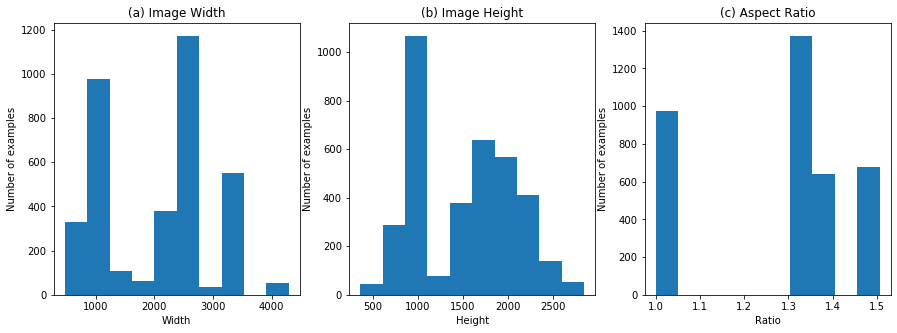

In [9]:
##### IMAGE SIZE DISTRIBUTION

fig = plt.figure(figsize = (15, 5))

# width
plt.subplot(1, 3, 1)
plt.hist(image_stats['width'])
plt.title('(a) Image Width')
plt.ylabel('Number of examples')
plt.xlabel('Width')

# height
plt.subplot(1, 3, 2)
plt.hist(image_stats['height'])
plt.title('(b) Image Height')
plt.ylabel('Number of examples')
plt.xlabel('Height')

# ratio
plt.subplot(1, 3, 3)
plt.hist(image_stats['ratio'])
plt.title('(c) Aspect Ratio')
plt.ylabel('Number of examples')
plt.xlabel('Ratio')

# export
plt.savefig('../figures/fig_size_distribution.pdf')